## NLP处理实例

### 数据集: Disasters on social media

推特（社交媒体）上有许多的信息，其中有关于灾难，疾病，暴乱的，有些只是开玩笑或者是电影情节，我们该如何让机器能分辨出这两种讨论呢？

### 为什么这很重要
我们将努力正确预测有关灾难的推文。这是一个非常相关的问题，因为：

* 对于任何试图从噪音中获取信号的人来说，这都是可以采取行动的(比如警察部门在这种情况下)。
* 这是很棘手的，因为依赖关键字比在大多数情况下像垃圾邮件更难。

###  任务
对文本数据进行分类，并分析找到相关归因。

In [19]:
import sklearn
from tensorflow import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs

### 数据输入
需要对数据做一下编码处理

In [38]:
input_file = codecs.open("data/socialmedia_relevant_cols.csv", "r",encoding='utf-8', errors='replace')
output_file = open("data/socialmedia_relevant_cols_clean.csv", "w",encoding='utf-8')

def sanitize_characters(raw, clean):    
    for line in input_file:
        out = line
        output_file.write(line)

In [39]:
sanitize_characters(input_file, output_file)

### 数据预处理

In [28]:
questions = pd.read_csv("data/socialmedia_relevant_cols_clean.csv")
questions.columns=['text', 'choose_one', 'class_label']
questions.head()

,text,choose_one,class_label
0,Just happened a terrible car crash,Relevant,1
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1
2,"Heard about #earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,Forest fire near La Ronge Sask. Canada,Relevant,1


可以看到数据里有“#”号，通常这是作为一个话题，点击能进入到话题页面。这里我们不需要，删除“#”字符，但保留“#”符号后面的单词，因为它们可能是相关的(例如：#灾难)

In [29]:
questions.describe()

,class_label
count,10813.000000
mean,0.431610
std,0.498302
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,2.000000


我们使用一些正则表达式来清理数据，并将其保存供将来使用

In [30]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

In [32]:
questions = standardize_text(questions, "text")
questions.to_csv("data/clean_data.csv")
questions.head()

,text,choose_one,class_label
0,just happened a terrible car crash,Relevant,1
1,our deeds are the reason of this earthquake m...,Relevant,1
2,"heard about earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,forest fire near la ronge sask canada,Relevant,1


In [33]:
clean_questions = pd.read_csv("data/clean_data.csv")  # 读取数据查看
clean_questions.head()

,Unnamed: 0,text,choose_one,class_label
0,0,just happened a terrible car crash,Relevant,1
1,1,our deeds are the reason of this earthquake m...,Relevant,1
2,2,"heard about earthquake is different cities, s...",Relevant,1
3,3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,4,forest fire near la ronge sask canada,Relevant,1


### 数据概述

查看正负样本分布情况

In [35]:
clean_questions.groupby("class_label").count()

,Unnamed: 0,text,choose_one
class_label,,,
0,6162,6162,6162
1,4635,4635,4635
2,16,16,16


样本看起来还毕竟均衡，1是与灾难相关，0是不相关，2是未知

### 数据处理

为了让模型能够理解文本数据，我们需要：
* 将句子标记为单独的单词列表
* 把数据分割成训练集和预测集
* 对我们的数据进行更多的检查以验证结果

In [41]:
from nltk.tokenize import RegexpTokenizer   # 分词器

tokenizer = RegexpTokenizer(r'\w+')

clean_questions["tokens"] = clean_questions["text"].apply(tokenizer.tokenize)  # 对指定列进行分词
clean_questions.head()

,Unnamed: 0,text,choose_one,class_label,tokens
0,0,just happened a terrible car crash,Relevant,1,"[just, happened, a, terrible, car, crash]"
1,1,our deeds are the reason of this earthquake m...,Relevant,1,"[our, deeds, are, the, reason, of, this, earth..."
2,2,"heard about earthquake is different cities, s...",Relevant,1,"[heard, about, earthquake, is, different, citi..."
3,3,"there is a forest fire at spot pond, geese are...",Relevant,1,"[there, is, a, forest, fire, at, spot, pond, g..."
4,4,forest fire near la ronge sask canada,Relevant,1,"[forest, fire, near, la, ronge, sask, canada]"


#### 语料库情况

In [43]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

all_words = [word for tokens in clean_questions["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in clean_questions["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

153895 words total, with a vocabulary size of 18065
Max sentence length is 34


不重复的词只有18065并不多，最大长度34，那么平均或者绝大多数是多少呢

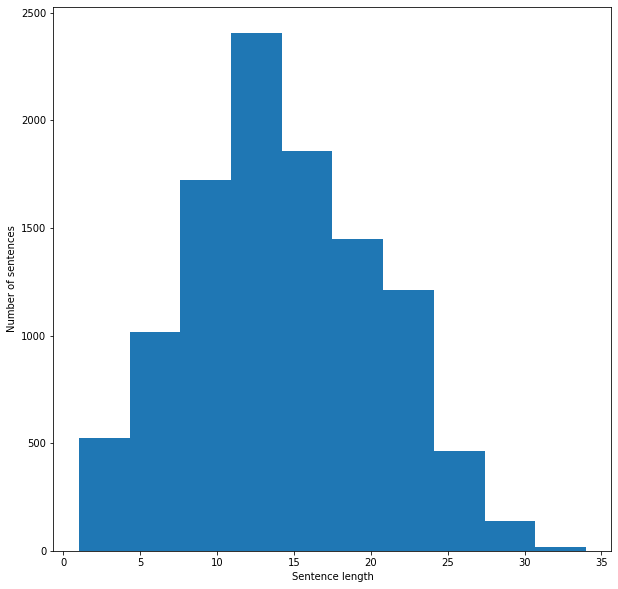

In [45]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

绝大多数在25以内，每个句子有长有短，长度起码要做到一致，去掉较长的小部分句子的后面内容。比如这里选25以内，那么句子大于25的词我们直接去掉。

这时候数据已经准备好了，让我们深入到机器学习部分。

### 机器学习

#### 输入Embedding

图像机器学习可以使用原始像素作为输入，欺诈检测算法可以利用客户特征，NLP可以使用什么？

为了让计算机理解文本，我们需要将文本进行编码(转成数值)，用什么样的数值来表达才能让模型准确地理解并进行预测分类呢。

最简单的方法就是词袋模型。

### Bag of Words Counts词袋模型
与第一句text的just happened a terrible car crash为例，上面已知有18065个不同的词，那么我们可以构造一个长度为18065的列表，假设just表示这长度为18065的列表的第3个索引，那么第三个索引内容为1，其它词也是一样，有则为1无则为0，出现两次则为2，第一句text会转成如下样子：

|索引1|索引2|索引3|索引4|...|索引18065|
|---|---|---|---|---|----|
|0|0|1|1|...|0|

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    # 将文本数据转换成数值
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

# 把数据转成列表形式
list_corpus = clean_questions["text"].tolist()  
list_labels = clean_questions["class_label"].tolist()

# 切分数据集成训练和预测
X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)  # 用相同的词袋对文本做转换

已知我们有1万多句话，也有仅2万个不同的词（维度），那么就是1万多 × 2万的维度。

### 可视化Word Embedding

现在我们已经创建了Embedding，让我们将它们可视化，看看是否能够识别某种结构。多维数据很难可视化，我们利用PCA技术降维到2维，进行可视化展示。

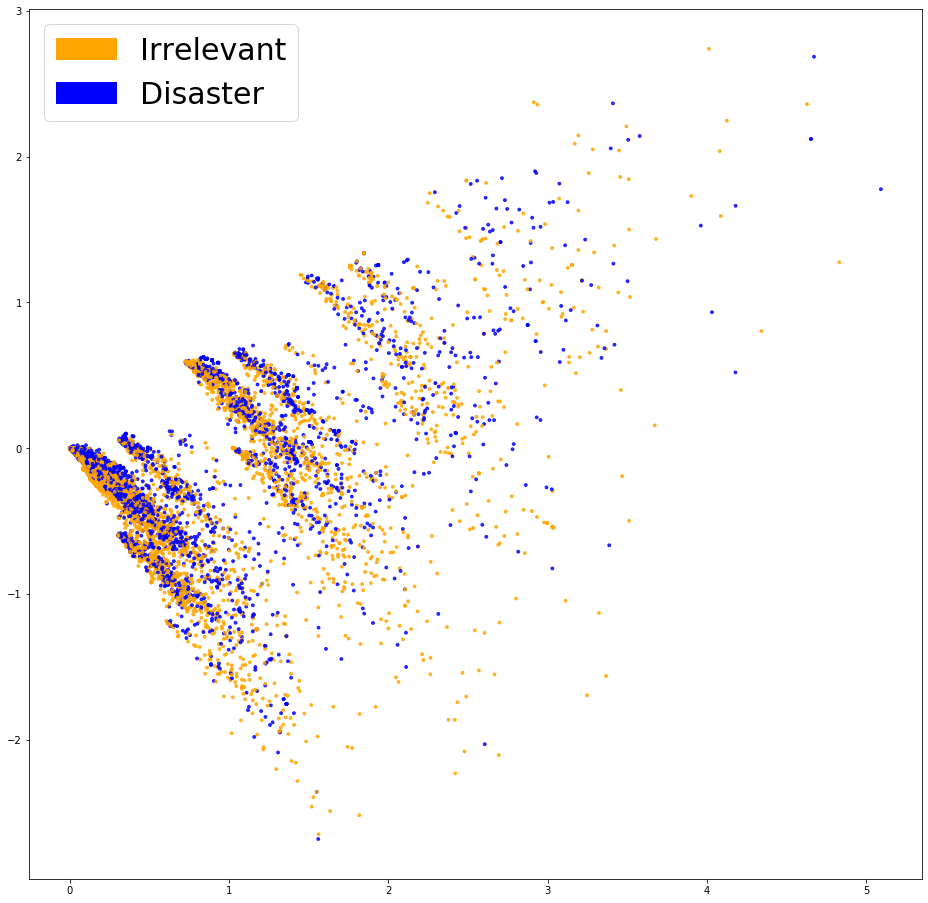

In [61]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Irrelevant')
            green_patch = mpatches.Patch(color='blue', label='Disaster')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

我们希望数据区分明显，但这些Embedding看起来并不是非常清晰地分开。我们尝试在上面建立一个有用的模型。

### 分类器

这里我们使用简单的逻辑回归做数据顶层模型，它能快速的训练预测，并容易理解。

In [62]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

### 评估
我们使用一些度量，看看我们的分类器的表现结果。

第一种是预测的“成功率”。

In [64]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.757, precision = 0.758, recall = 0.757, f1 = 0.757


准确率(accuracy) = 0.757，表示100个中有75.7%的概率预测正确。精确率(precision) = 0.758, 召回率(recall) = 0.757, f1 = 0.757。

### 混淆矩阵

第二种是查看具体的预测情况。

In [65]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

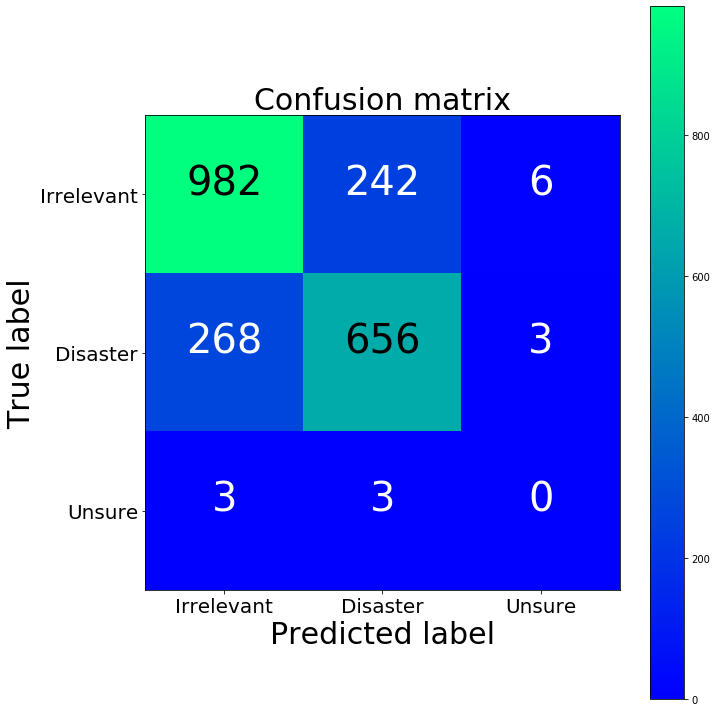

[[982 242   6]
 [268 656   3]
 [  3   3   0]]


In [66]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

左上角的982为预测不相关且实际为不相关的，中间的656为预测灾难和实际灾难的，Unsure不确定的几乎没有，原本的样本也不多。

### 进一步检查模型的关注点

第三种是查看下分类器决策的特性，即它是以哪些词来区分的。

使用逻辑回归的好处就是，可解释性非常高，因为其公式可推导，可以知道每个值的大小。

In [67]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}  # 给每个词做index
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        # 获取模型的系数（词的重要程度），获取前几个和后几个。
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

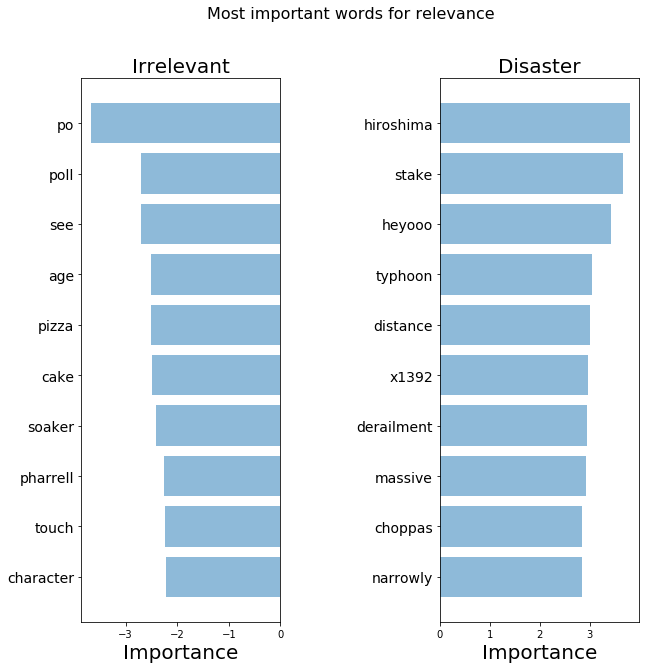

In [68]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Disaster', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[1]['tops']]
top_words = [a[1] for a in importance[1]['tops']]
bottom_scores = [a[0] for a in importance[1]['bottom']]
bottom_words = [a[1] for a in importance[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

我们的分类器正确地识别了如：hiroshima、massacre，但heyooo、x1392显然应该是不相关。

### TFIDF Bag of Words

在词袋模型上，我们使用TF-ID(术语频率，反向文档频率)，它意味着根据词在我们的数据集中的频率来衡量该词在某段话中出现的频率，排除噪音。

如：年龄这个词，在全部语句中出现的次数很多，在这段话出现的次数也很多，可以认为是噪音适当降低权重，而hiroshima在全部语句中出现次数极少，在这段话出现的此时多，表明hiroshima对这段话有一定的权重。

In [69]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

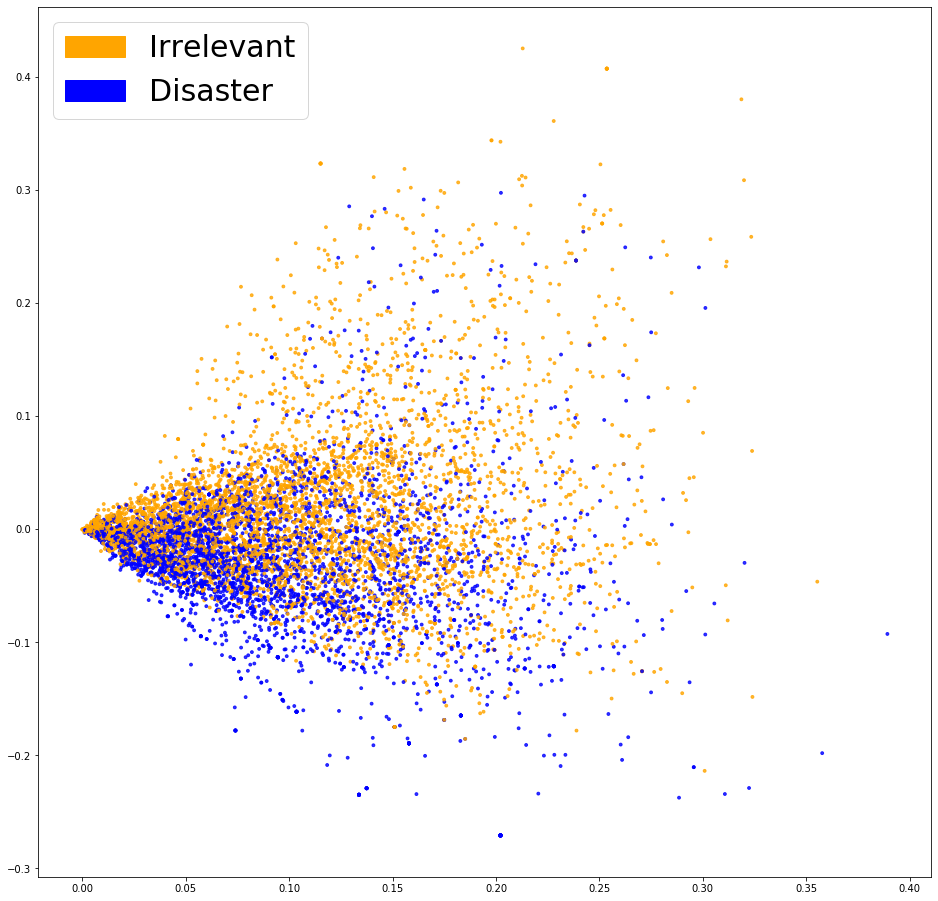

In [70]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

这样看两者区分的更开了，我们再试试分类器的效果。

In [71]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [72]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.773, precision = 0.772, recall = 0.773, f1 = 0.772


所有指标都比之前更好了，在看看其它差异

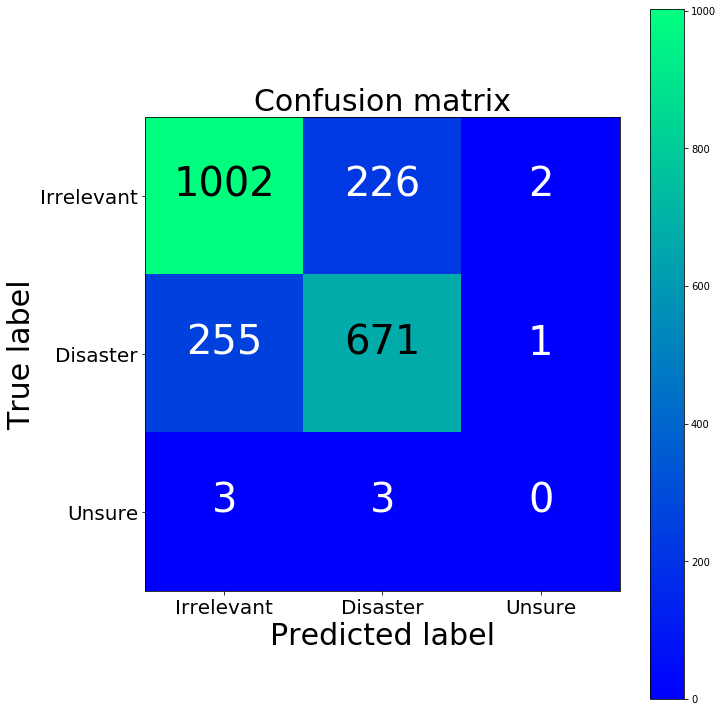

TFIDF confusion matrix
[[1002  226    2]
 [ 255  671    1]
 [   3    3    0]]
BoW confusion matrix
[[982 242   6]
 [268 656   3]
 [  3   3   0]]


In [73]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

### 词语的解释

In [74]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

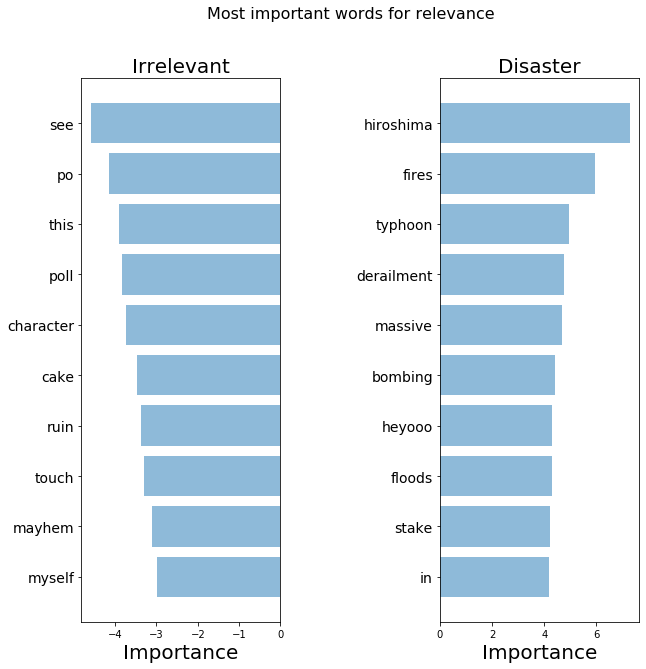

In [75]:
top_scores = [a[0] for a in importance_tfidf[1]['tops']]
top_words = [a[1] for a in importance_tfidf[1]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[1]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

所选的词语更加贴切了，如fi